
# Advanced Lane Finding Project
## The goals / steps of this project are the following:
* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

## Import necessary functions

In [1]:
import cv2
import numpy as np
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tqdm import tqdm
%matplotlib inline

## Initialize variables

In [2]:
nx = 9
ny = 6

## Methods definitions:

In [3]:
#def cal_undistort(img, objpoints, imgpoints):

def find_points(nx,ny):    
    
    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.
    
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((nx*ny,3), np.float32)


    objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)
    # Make a list of calibration images
    images = glob.glob('camera_cal/cal*.jpg')

    # Step through the list and search for chessboard corners
    for idx, fname in enumerate(images):
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

            # Draw and display the corners
            cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
            write_name = 'output_images/corners_found'+str(idx)+'.jpg'
            cv2.imwrite(write_name, img)
            cv2.imshow('img', img)
            cv2.waitKey(500)

    cv2.destroyAllWindows()
    return objpoints,imgpoints



In [4]:
def get_coeffs(img, objpoints, imgpoints):
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    img_size = (img.shape[1], img.shape[0])
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
    return mtx, dist

In [5]:
def gradx_thresh(img, sobel_kernel=3, thresh=(0,255)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    # 2) Take the derivative in x
    # 3) Take the absolute value of the derivative
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    # 6) Return this mask as your binary_output image
    
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)


    #print("sobel", sobel)
    abs_sobel = np.absolute(sobel)
    #print("abs", abs_sobel)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    #print("sc",scaled_sobel)
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel > thresh[0]) & (scaled_sobel < thresh[1])] = 1
    
    return sxbinary

In [6]:
def hls_s_select(img, thresh=(0, 255)):
    # 1) Convert to HLS color space
    # 2) Apply a threshold to the S channel
    # 3) Return a binary image of threshold result
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)

    S = hls[:,:,2]

    binary = np.zeros_like(S)
    binary[(S > thresh[0]) & (S <= thresh[1])] = 1
    
    return binary

In [7]:
def lab_b_select(img, thresh=(0,255)):
    # 1) Convert to LAB color space
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2Lab)
    lab_b = lab[:,:,2]
    # don't normalize if there are no yellows in the image
    if np.max(lab_b) > 175:
        lab_b = lab_b*(255/np.max(lab_b))
    # 2) Apply a threshold to the L channel
    binary = np.zeros_like(lab_b)
    binary[((lab_b > thresh[0]) & (lab_b <= thresh[1]))] = 1
    # 3) Return a binary image of threshold result
    return binary

In [8]:
def hls_l_select(img, thresh=(220, 255)):
    # 1) Convert to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    hls_l = hls[:,:,1]
    hls_l = hls_l*(255/np.max(hls_l))
    # 2) Apply a threshold to the L channel
    binary = np.zeros_like(hls_l)
    binary[(hls_l > thresh[0]) & (hls_l <= thresh[1])] = 1
    # 3) Return a binary image of threshold result
    return binary

In [9]:
def get_binary_image(img):
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

    gradx = gradx_thresh(img, sobel_kernel=3, thresh=(20, 100))

    #s_binary = hls_s_select(img,thresh=(170, 255))
    
    b_binary = lab_b_select(img,thresh=(190,255))
    
    l_binary = hls_l_select(img)

    out = np.zeros_like(gradx)
    out[ (gradx == 1) | (l_binary == 1) | (b_binary == 1)] = 1
    return out

In [10]:
def perspective_transform(image):
    #gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    img_size = (image.shape[1], image.shape[0])
    
    bottom_left = [220,720]
    bottom_right = [1110, 720]
    top_left = [570, 470]
    top_right = [722, 470]

    src = np.float32([bottom_left,bottom_right,top_right,top_left])
    
    
    bottom_left = [320,720]
    bottom_right = [920, 720]
    top_left = [320, 1]
    top_right = [920, 1]

    dst = np.float32([bottom_left,bottom_right,top_right,top_left])
    
    #src = np.float32(
     #   [[(img_size[0] / 2) - 55, img_size[1] / 2 + 100],
      #  [((img_size[0] / 6) - 10), img_size[1]-40],
       # [(img_size[0] * 5 / 6) + 60, img_size[1]-40],
        #[(img_size[0] / 2 + 55), img_size[1] / 2 + 100]])
    #print(src)
    #dst = np.float32(
     #   [[(img_size[0] / 4), 0],
      #  [(img_size[0] / 4), img_size[1]],
       # [(img_size[0] * 3 / 4), img_size[1]],
        #[(img_size[0] * 3 / 4), 0]])
    #print(dst)
    M = cv2.getPerspectiveTransform(src,dst)
    M_Inv = cv2.getPerspectiveTransform(dst,src)

    warped = cv2.warpPerspective(image, M, img_size, flags=cv2.INTER_LINEAR)
    return warped, M_Inv

In [11]:
def basic_transformations(img,mtx,dist):
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    warped, M_Inv = perspective_transform(dst)
    
    binary_warped = get_binary_image(warped)
    
    return binary_warped, M_Inv
    

## Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.

In [12]:
objpoints,imgpoints = find_points(nx,ny)
img = cv2.imread("camera_cal\calibration1.jpg")
mtx, dist = get_coeffs(img,objpoints,imgpoints)
#print("obj",objpoints,"img",imgpoints)

## Displaying a sample image before and after un distortion

Image before un distortion


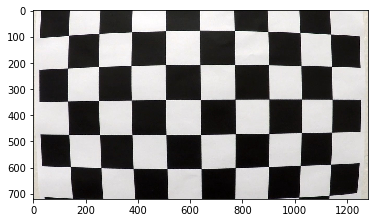

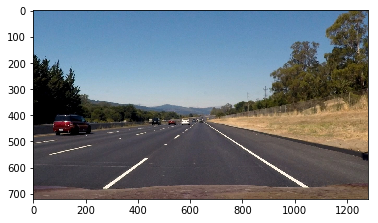

Image after un distortion


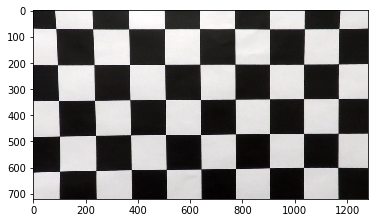

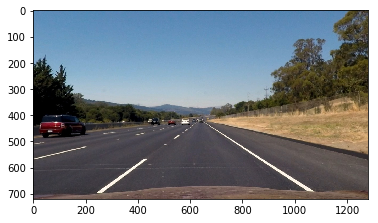

In [13]:
img = cv2.imread("camera_cal\calibration1.jpg")
img2 = cv2.imread("test_images\straight_lines2.jpg")

img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(img2,cv2.COLOR_BGR2RGB)

print("Image before un distortion")
plt.imshow(img,cmap='gray')
plt.show()

plt.imshow(img2,cmap='gray')
plt.show()


dst = cv2.undistort(img, mtx, dist, None, mtx)
dst2 = cv2.undistort(img2, mtx, dist, None, mtx)

print("Image after un distortion")
plt.imshow(dst,cmap='gray')
plt.show()

plt.imshow(dst2,cmap='gray')
plt.show()


## Displaying sample images after applying color transforms, x gradient to create a thresholded binary image.

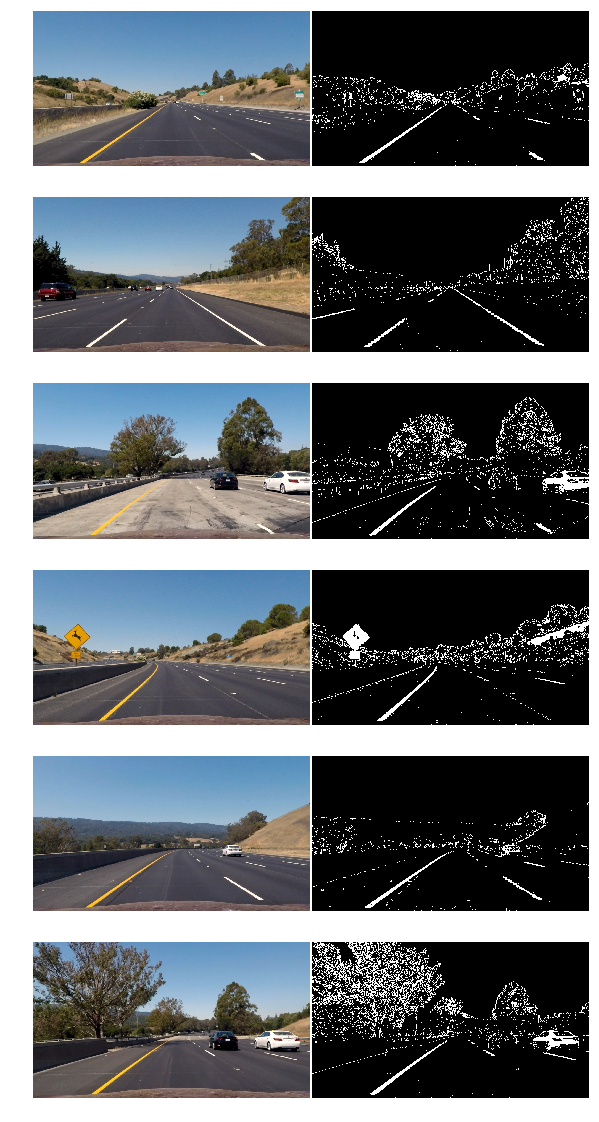

In [14]:
#img = cv2.imread("test_images\straight_lines2.jpg")

#rgb = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

#print("Image before converting to binary image")
#plt.imshow(rgb,cmap='gray')
#plt.show()

#img = cv2.undistort(img, mtx, dist, None, mtx)
#out = get_binary_image(img)
#print("Image after converting to binary image")
#plt.imshow(out,cmap='gray')
#plt.show()

images = glob.glob('./test_images/*.jpg')
                                          
# Set up plot
fig, axs = plt.subplots(len(images),2, figsize=(10, 20))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()
                  
i = 0
for image in images:
    img = cv2.imread(image)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    img = cv2.undistort(img, mtx, dist, None, mtx)
    img_out = get_binary_image(img)
    axs[i].imshow(img)
    axs[i].axis('off')
    i += 1
    axs[i].imshow(img_out, cmap='gray')
    axs[i].axis('off')
    i += 1

# Displaying images after applying perspective transform

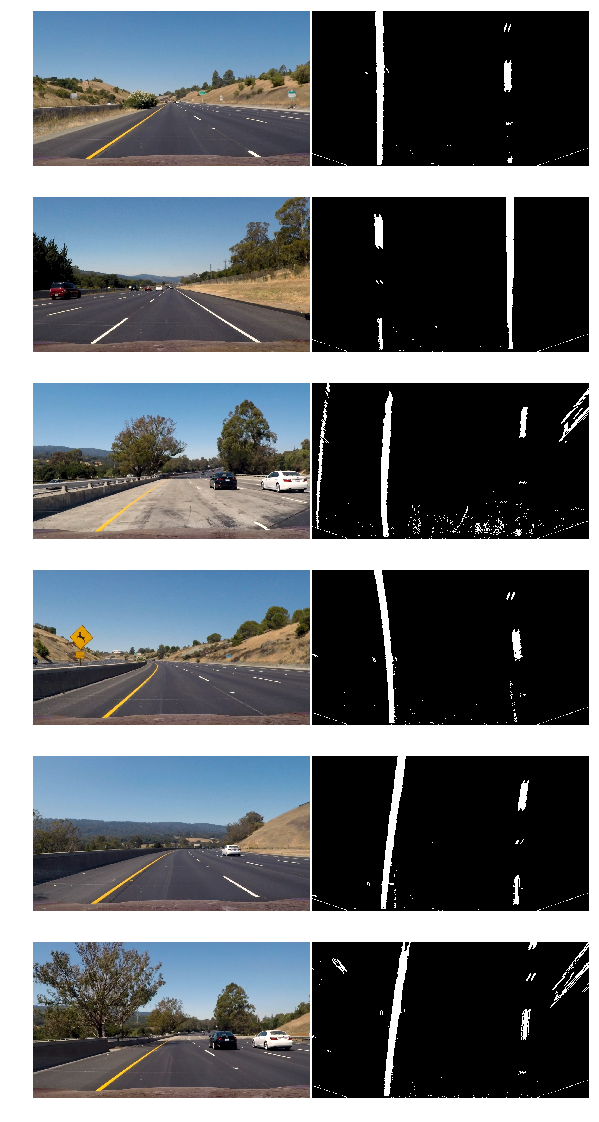

In [15]:
# Running the basic transformations upto perspective transformation on all of the test images given
# to get an intuition on what is needed and what is lacking in our model.
images = glob.glob('./test_images/*.jpg')
                                          
# Set up plot
fig, axs = plt.subplots(len(images),2, figsize=(10, 20))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()
                  
i = 0
for image in images:
    img = cv2.imread(image)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_out, M_Inv = basic_transformations(img,mtx,dist)
    axs[i].imshow(img)
    axs[i].axis('off')
    i += 1
    axs[i].imshow(img_out, cmap='gray')
    axs[i].axis('off')
    i += 1

## Defining new_fit to get the left and right lane lines using the histogram value and performing blind search using sliding windows

In [16]:
def new_fit(binary_warped):
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)

    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    #midpoint = np.int(histogram.shape[0]/2)
    #leftx_base = np.argmax(histogram[:midpoint])
    #rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    midpoint = np.int(histogram.shape[0]//2)
    quarter_point = np.int(midpoint//2)
    # Previously the left/right base was the max of the left/right half of the histogram
    # this changes it so that only a quarter of the histogram (directly to the left/right) is considered
    leftx_base = np.argmax(histogram[quarter_point:midpoint]) + quarter_point
    rightx_base = np.argmax(histogram[midpoint:(midpoint+quarter_point)]) + midpoint
    
    # Choose the number of sliding windows
    nwindows = 10
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    #print(binary_warped.shape)

    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    #print(nonzerox)
    #print(nonzeroy)
    #break
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 80
    # Set minimum number of pixels found to recenter window
    minpix = 40
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    visualize = []
    
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        #print(window)
        #print(window_height)
        #break
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        visualize.append((win_y_low, win_y_high, win_xleft_low, win_xleft_high, win_xright_low, win_xright_high))
        
        #print(((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        #(nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0])
        #break
        #print(((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &     (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero())
        #print(nonzeroy[((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]])

        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]

        #print(nonzerox[good_left_inds])
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        #print(nonzerox[good_right_inds])
        #break

        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    return left_fit, right_fit, left_lane_inds, right_lane_inds,histogram,visualize

## Visualizing a sample image after using histogram data and sliding window mechanism to find the lines in a frame.

The histogram for the frame :


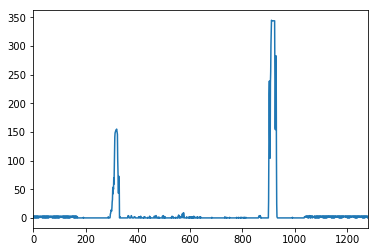

The sliding window details for the frame


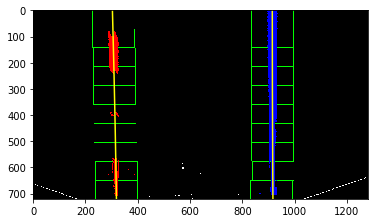

In [17]:


img = cv2.imread("test_images\straight_lines2.jpg")

binary_warped, M_Inv = basic_transformations(img,mtx,dist)

left_fit, right_fit, left_lane_inds, right_lane_inds,histogram,visualize = new_fit(binary_warped)

print("The histogram for the frame :")
plt.plot(histogram)
plt.xlim(0, 1280)
plt.show()

# Create an output image to draw on and  visualize the result
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )

left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

#print(left_lane_inds.shape[0])
# Draw the windows on the visualization image
for rect in visualize:
    cv2.rectangle(out_img,(rect[2],rect[0]),(rect[3],rect[1]),(0,255,0), 2) 
    cv2.rectangle(out_img,(rect[4],rect[0]),(rect[5],rect[1]),(0,255,0), 2)
    
# Identify the x and y positions of all nonzero pixels in the image
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
        
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

print("The sliding window details for the frame")
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)
plt.show()

## Defining use_prev_fit to find lane lines from where we left in the previous frame.

In [18]:
def use_prev_fit(binary_warped,left_fit,right_fit):
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 80
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
    left_fit[1]*nonzeroy + left_fit[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
    right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    return left_fit, right_fit, left_lane_inds, right_lane_inds

## Visualizing a sample image after using the existing fit from previous image

A sample image after using the existing fit from previous image


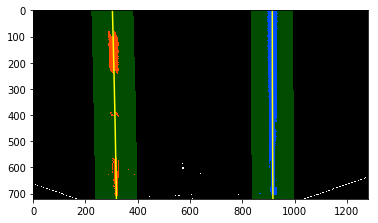

In [36]:
img = cv2.imread("test_images\straight_lines2.jpg")

binary_warped, M_Inv = basic_transformations(img,mtx,dist)

left_fit, right_fit, left_lane_inds, right_lane_inds = use_prev_fit(binary_warped,left_fit,right_fit)

out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
window_img = np.zeros_like(out_img)

# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
#plt.imshow(out_img)
#plt.show()
margin = 80
# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)

print("A sample image after using the existing fit from previous image")

plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)
plt.show()

## Defining calc_rad_center to find the radius of the curvature and to find the distance from lane center

In [20]:
def calc_rad_center(img,left_fit, right_fit, left_lane_inds, right_lane_inds):    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    #size = img.shape[0]
    #ploty = np.linspace(0, size-1, size)
    
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    #leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
    #rightx = rightx[::-1]  # Reverse to match top-to-bottom in y
    
    #print(len(leftx))
    #print(left_lane_inds.shape)
    #print((ploty*ym_per_pix).shape[0], (leftx*xm_per_pix).shape[0])
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    
    y_evall = np.max(lefty)
    y_evalr = np.max(righty)
    
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_evall*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_evalr*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])

    center_dist = 0
    # Distance from center is image x midpoint - mean of l_fit and r_fit intercepts 
    if right_fit is not None and left_fit is not None:
        car_position = img.shape[1]/2
        h = img.shape[0]
        l_fit_x_int = left_fit[0]*h**2 + left_fit[1]*h + left_fit[2]
        r_fit_x_int = right_fit[0]*h**2 + right_fit[1]*h + right_fit[2]
        lane_center_position = (r_fit_x_int + l_fit_x_int) /2
        #print(lane_center_position,"<---- center")
        center_dist = abs((car_position - lane_center_position) * xm_per_pix)

        
    return left_curverad, right_curverad, center_dist

In [21]:
img = cv2.imread("test_images\straight_lines2.jpg")

binary_warped, M_Inv = basic_transformations(img,mtx,dist)

left_fit, right_fit, left_lane_inds, right_lane_inds,histogram,visualize = new_fit(binary_warped)

#left_fit1, right_fit1, left_lane_inds1, right_lane_inds1 = use_prev_fit(binary_warped,left_fit,right_fit)

rad_l, rad_r, d_center = calc_rad_center(binary_warped,left_fit, right_fit, left_lane_inds, right_lane_inds)

print('Radius of curvature:', rad_l, 'm,', rad_r, 'm')
print('Center offset:', d_center, 'm')

Radius of curvature: 19294.0653487 m, 35456.5175338 m
Center offset: 0.117169568683 m


## Defining fill_color2original_image to fill color inside the lane line boundaries that we found on perspective transformed image and then transforming the perpective image to original image.

In [22]:
def fill_color2original_image(original_img, binary_img, l_fit, r_fit, Minv):
    new_img = np.copy(original_img)
    if l_fit is None or r_fit is None:
        return original_img
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_img)#.astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    h,w = binary_img.shape
    ploty = np.linspace(0, h-1, num=h)# to cover same y-range as image
    left_fitx = l_fit[0]*ploty**2 + l_fit[1]*ploty + l_fit[2]
    right_fitx = r_fit[0]*ploty**2 + r_fit[1]*ploty + r_fit[2]

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    cv2.polylines(color_warp, np.int32([pts_left]), isClosed=False, color=(255,0,0), thickness=15)
    cv2.polylines(color_warp, np.int32([pts_right]), isClosed=False, color=(255,0,0), thickness=15)
    
    #plt.imshow(color_warp,cmap='gray')
    #plt.show()
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (w, h)) 
    #plt.imshow(newwarp,cmap='gray')
    #plt.show()
    
    # Combine the result with the original image
    result = cv2.addWeighted(new_img, 1, newwarp, 0.5, 0)
    return result



The binary transformed and perspective transformed image


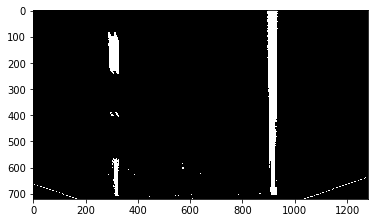

Color filled back on to the original image


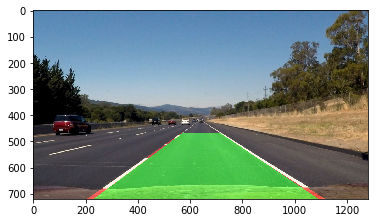

In [23]:

img = cv2.imread("test_images\straight_lines2.jpg")

binary_warped, M_Inv = basic_transformations(img,mtx,dist)
print("The binary transformed and perspective transformed image")

plt.imshow(binary_warped,cmap="gray")
plt.show()
left_fit, right_fit, left_lane_inds, right_lane_inds,histogram,visualize = new_fit(binary_warped)
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
out1 = fill_color2original_image(img, binary_warped, left_fit, right_fit, M_Inv)

print("Color filled back on to the original image")
plt.imshow(out1,cmap="gray")
plt.show()

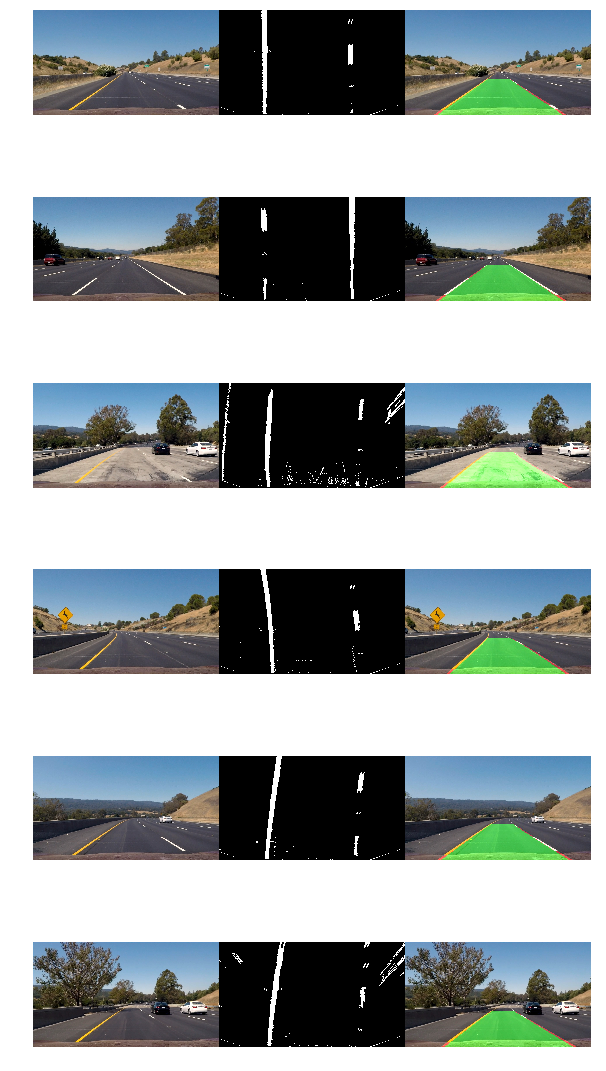

In [24]:
# Running the basic transformations upto perspective transformation on all of the test images given
# to get an intuition on what is needed and what is lacking in our model.
images = glob.glob('./test_images/*.jpg')
                                          
# Set up plot
fig, axs = plt.subplots(len(images),3, figsize=(10, 20))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()
                  
i = 0
for image in images:
    img = cv2.imread(image)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    binary_warped, M_Inv = basic_transformations(img,mtx,dist)

    left_fit, right_fit, left_lane_inds, right_lane_inds,histogram,visualize = new_fit(binary_warped)
    #img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    out1 = fill_color2original_image(img, binary_warped, left_fit, right_fit, M_Inv)
    
    axs[i].imshow(img, cmap='gray')
    axs[i].axis('off')
    i += 1
    axs[i].imshow(binary_warped, cmap='gray')
    axs[i].axis('off')
    i += 1
    axs[i].imshow(out1, cmap='gray')
    axs[i].axis('off')
    i += 1

## Defining write_rad_center to write the radius of the curvature and distance from center of the lane back on to the top of the original image

In [25]:
def write_rad_center(original_img, curv_rad, center_dist):
    new_img = np.copy(original_img)
    h = new_img.shape[0]
    font = cv2.FONT_HERSHEY_TRIPLEX
    text = 'Curve radius: ' + '{:04.4f}'.format(curv_rad) + 'm'
    cv2.putText(new_img, text, (40,70), font, 1.5, (200,255,155), 2, cv2.LINE_AA)

    text = 'Center offset:  ' + '{:04.4f}'.format(center_dist)
    cv2.putText(new_img, text, (40,120), font, 1.5, (200,255,155), 2, cv2.LINE_AA)
    return new_img

The binary transformed and perspective transformed image


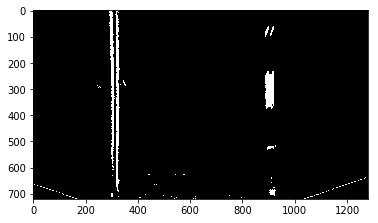

Color filled back on to the original image


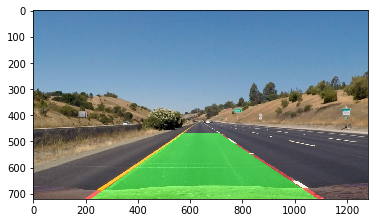

Radius and Center written on to the original image


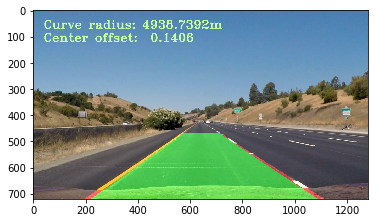

In [26]:


img = cv2.imread("test_images\straight_lines1.jpg")

print("The binary transformed and perspective transformed image")
binary_warped, M_Inv = basic_transformations(img,mtx,dist)
plt.imshow(binary_warped,cmap="gray")
plt.show()

left_fit, right_fit, left_lane_inds, right_lane_inds,histogram,visualize = new_fit(binary_warped)
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
print("Color filled back on to the original image")
out1 = fill_color2original_image(img, binary_warped, left_fit, right_fit, M_Inv)
plt.imshow(out1,cmap="gray")
plt.show()

rad_l, rad_r, center = calc_rad_center(binary_warped,left_fit, right_fit, left_lane_inds, right_lane_inds)
#print(rad_l, rad_r)
out2 = write_rad_center(out1, (rad_l+rad_r)/2, center)
print("Radius and Center written on to the original image")
plt.imshow(out2)
plt.show()

In [27]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False 
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = []  
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        self.c = 0
        
    def add_fit(self, fit, inds):
        # add a found fit to the line, up to 5
        if fit is not None:
            if self.best_fit is not None:
                # if we have a best fit, see how this new fit compares
                self.diffs = abs(fit-self.best_fit)
            if (self.diffs[0] > 0.001 or \
               self.diffs[1] > 1.0 or \
               self.diffs[2] > 100.) and \
               len(self.current_fit) > 0:
                # bad fit
                self.detected = False
            else:
                self.detected = True
                self.current_fit.append(fit)
                if len(self.current_fit) > 5:
                    
                    self.current_fit = self.current_fit[len(self.current_fit)-5:]
                self.best_fit = np.average(self.current_fit, axis=0)
        
        else:
            self.detected = False
            if len(self.current_fit) > 0:
                
                self.current_fit = self.current_fit[:len(self.current_fit)-1]
            if len(self.current_fit) > 0:
                # if there are still any fits in the queue, best_fit is their average
                self.best_fit = np.average(self.current_fit, axis=0)

In [28]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML


In [29]:
def pipeline(img):
    

    binary_warped, M_Inv = basic_transformations(img,mtx,dist)
    
    if not l_line.detected or not r_line.detected:
        left_fit, right_fit, left_lane_inds, right_lane_inds,histogram,visualize = new_fit(binary_warped)
    else:
        left_fit, right_fit, left_lane_inds, right_lane_inds = use_prev_fit(binary_warped,l_line.best_fit, r_line.best_fit)
    
    
        # invalidate both fits if the difference in their x-intercepts isn't around +-100 compared with 350 px
    if left_fit is not None and right_fit is not None:
        
        h = img.shape[0]
        l_fit_x_int = left_fit[0]*h**2 + left_fit[1]*h + left_fit[2]
        r_fit_x_int = right_fit[0]*h**2 + right_fit[1]*h + right_fit[2]
        x_int_diff = abs(r_fit_x_int-l_fit_x_int)
        if abs(350 - x_int_diff) > 100:
            l_fit = None
            r_fit = None
            
    l_line.add_fit(left_fit, left_lane_inds)
    r_line.add_fit(right_fit, right_lane_inds)
    
    
    if l_line.best_fit is not None and r_line.best_fit is not None:

        out1 = fill_color2original_image(img, binary_warped, left_fit, right_fit, M_Inv)

        rad_l, rad_r, center = calc_rad_center(binary_warped,left_fit, right_fit, left_lane_inds, right_lane_inds)

        out2 = write_rad_center(out1, (rad_l+rad_r)/2, center)

    else:
        out2 = img
    
    return out2

In [30]:
l_line = Line()
r_line = Line()

output = "output_project_video.mp4"

clip1 = VideoFileClip("project_video.mp4")#.subclip(21,26)#(38,46)

clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!

%time clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video output_project_video.mp4
[MoviePy] Writing video output_project_video.mp4


100%|█████████████████████████████████████▉| 1260/1261 [12:51<00:00,  1.79it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_project_video.mp4 

Wall time: 12min 56s


In [31]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))